# Purpose 
This notebook calculates predicton intervals for models of different flexibility (from OLS to gradient boosted trees) using a food delivery dataset. 
Background is the interest in the uncertainty around an individual prediction. For example it could be valuable to the enduser to not only know the point prediction of delivery time, but also the likely spread around the point prediction, e.g., how much faster or slower the ordered food can be expected to arrive within a certain level of confidence.
The prediction interval is different from model evaluation metrics such as the mean absolute error (MAE). The test MAE gives the average difference between predicted and actual responses, i.e., it can be interpreted as the expected difference for new data points from the same distribution as the training set. In contrast, the prediction interval reports the uncertainty of an individual prediction. 

Ressources used:
https://www.valencekjell.com/posts/2022-09-14-prediction-intervals/#ref-jackknife_plus_2021
https://machinelearningmastery.com/prediction-intervals-for-machine-learning/
https://medium.com/bain-inside-advanced-analytics/conformal-prediction-an-easy-way-to-estimate-prediction-intervals-c0de34c47494
https://mapie.readthedocs.io/en/latest/index.html#

# Creating and preparing dataframe

In [16]:
import numpy as np # For linear algebra
import pandas as pd # For creating data frame
import matplotlib.pyplot as plt # For plotting chart
import seaborn as sns # For creating data visualization


# Creating data frame by reading csv file
df = pd.read_csv('/kaggle/input/food-delivery-time/deliverytime.csv')
df.head()


,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Time_taken(min)
0,4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,Snack,motorcycle,24
1,B379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,Snack,scooter,33
2,5D6D,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,Drinks,motorcycle,26
3,7A6A,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,Buffet,motorcycle,21
4,70A2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,Snack,scooter,30


In [17]:
print(df.dtypes) 
df.nunique()

ID                              object
Delivery_person_ID              object
Delivery_person_Age              int64
Delivery_person_Ratings        float64
Restaurant_latitude            float64
Restaurant_longitude           float64
Delivery_location_latitude     float64
Delivery_location_longitude    float64
Type_of_order                   object
Type_of_vehicle                 object
Time_taken(min)                  int64
dtype: object


ID                             45451
Delivery_person_ID              1320
Delivery_person_Age               22
Delivery_person_Ratings           28
Restaurant_latitude              657
Restaurant_longitude             518
Delivery_location_latitude      4373
Delivery_location_longitude     4373
Type_of_order                      4
Type_of_vehicle                    4
Time_taken(min)                   45
dtype: int64

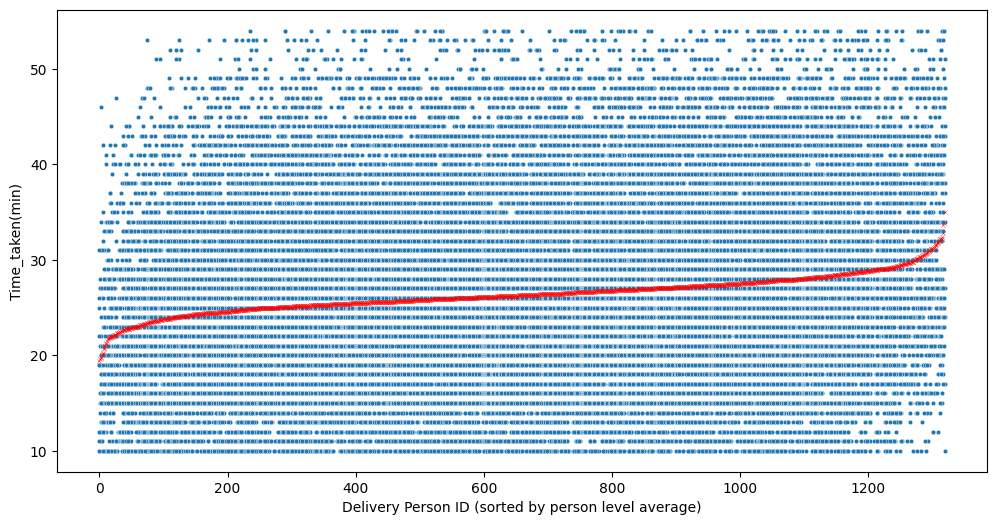

In [18]:
# data structure 
# it becomes apparent that this is a multilevel panel data structure: delivery person- delivery - restaurant - city 
## -> check if there are fixed effects on the level of the delivery person
## the delivery person holds information (urban vs. rural, time of working ...) that is otherwise not included in the dataset 

# create an identifier for a person and an identifier for their deliveries 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
integer_values = label_encoder.fit_transform(df["Delivery_person_ID"])
df.insert(0, 'Person_ID', integer_values)
df = df.drop(['Delivery_person_ID', "ID"], axis=1)
df = df.sort_values('Person_ID')
delivery_id= df.groupby('Person_ID').cumcount() + 1
df.insert(1, 'delivery_id', delivery_id)


# Calculate means by Person_ID (Person_level_mean)
means = df.groupby('Person_ID')['Time_taken(min)'].mean().reset_index()
sorted_means = means.sort_values(by='Time_taken(min)').reset_index(drop=True)
sorted_means['sort_id'] = sorted_means.index
# Add points for the meansdelivery_id= df.groupby('Person_ID').cumcount() + 1

# merge the avrages and the sort_id to the main df 
sorted_means = sorted_means.rename(columns={'Time_taken(min)': 'av_time_person'})
times=df[["Person_ID", "Time_taken(min)"]]
times = pd.merge(times, sorted_means, on='Person_ID', how='left')

plt.figure(figsize=(12, 6))
sns.scatterplot(x='sort_id', y='Time_taken(min)', data=times,  s=10)
sns.scatterplot(x='sort_id', y='av_time_person', data=sorted_means, color='red', marker='x', s=10)
plt.xlabel("Delivery Person ID (sorted by person level average)")
plt.show()

most of the variability in delivery time is coming from within the delivery person, suggesting no informational content of individual or unmeasured properties of the delivery person. Thus no big informational loss occurs treating the dataset as pooled.  

In [19]:
# a variance decomposition confirms the graphical finding: 
# variance decomposition 
time_within=df.groupby('Person_ID')["Time_taken(min)"].transform(lambda x: x - np.mean(x))

time_between = df.groupby('Person_ID')['Time_taken(min)'].mean().reset_index()

print("global mean/std\n", df["Time_taken(min)"].describe().apply("{0:.2f}".format), "between std\n",time_between["Time_taken(min)"].describe().apply("{0:.2f}".format),"\nWithin std\n", time_within.describe().apply("{0:.2f}".format) )
## much more within than between variance 

global mean/std
 count    45593.00
mean        26.29
std          9.38
min         10.00
25%         19.00
50%         26.00
75%         32.00
max         54.00
Name: Time_taken(min), dtype: object between std
 count    1320.00
mean       26.35
std         1.94
min        19.44
25%        25.21
50%        26.28
75%        27.46
max        35.00
Name: Time_taken(min), dtype: object 
Within std
 count    45593.00
mean         0.00
std          9.26
min        -25.00
25%         -7.19
50%         -0.78
75%          5.95
max         29.62
Name: Time_taken(min), dtype: object


<Axes: xlabel='Restaurant_longitude', ylabel='Restaurant_latitude'>

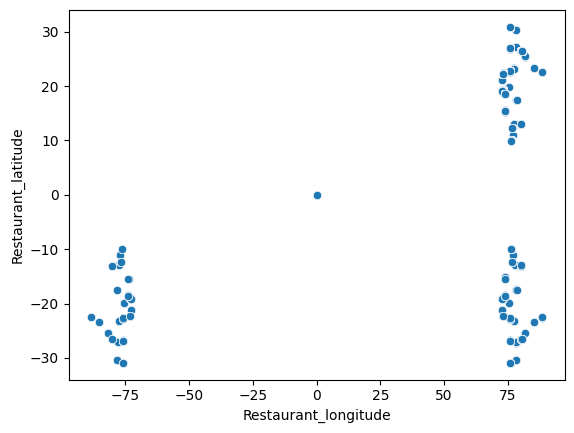

In [20]:
# check location of restaurants 
sns.scatterplot(data=df,x='Restaurant_longitude', y='Restaurant_latitude')

In [21]:
# the negative values are clearly wrongly coded 
df["Restaurant_longitude"].where(df["Restaurant_longitude"]==0).shape
mask = df['Restaurant_longitude'] == 0
df = df[~mask]

## all negative valuse are in front of the coast of Chile and Peru
df['Restaurant_longitude'] = df['Restaurant_longitude'].abs()
df['Restaurant_latitude'] = df['Restaurant_latitude'].abs()

In [22]:
# check on map using folium 
import folium

# add restaurant ID 
df.insert(loc=4, column='restaurant_id', value=df.set_index(['Restaurant_longitude','Restaurant_latitude']).index.factorize()[0]+1)

# Make an empty map
m= folium.Map(location=[20.5937, 78.9629], tiles="OpenStreetMap", zoom_start=5)
# add marker one by one on the map
# make dataset with each restaurant only one time -> saves time and space, 388 markers vs 5000
df_rests=df[["restaurant_id", "Restaurant_latitude", "Restaurant_longitude"] ]
df_rests=df_rests.drop_duplicates()
df_rests

for i in range(0,len(df_rests)):
   folium.Marker(
      location=[df_rests.iloc[i]['Restaurant_latitude'], df_rests.iloc[i]['Restaurant_longitude']],
      popup=df_rests.iloc[i]['restaurant_id'],
   ).add_to(m)

# Show the map again
m

In [23]:
df=df.rename(columns={"Time_taken(min)": "time"})

## calculate distance 
import math
# function to calculate distance between two points if we have langitude and latitude
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Differences in latitude and longitude
    Δlat = lat2 - lat1
    Δlon = lon2 - lon1

    # Haversine formula
    a = math.sin(Δlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(Δlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    R = 6371  # Earth's mean radius in kilometers
    d = R * c

    return d
df['distance'] = np.vectorize(haversine)(df['Restaurant_latitude'], df['Restaurant_longitude'], df['Delivery_location_latitude'], df['Delivery_location_longitude'])


# Exploring relationship between time and various factors 

## Relationship between time and continous factors

<Axes: >

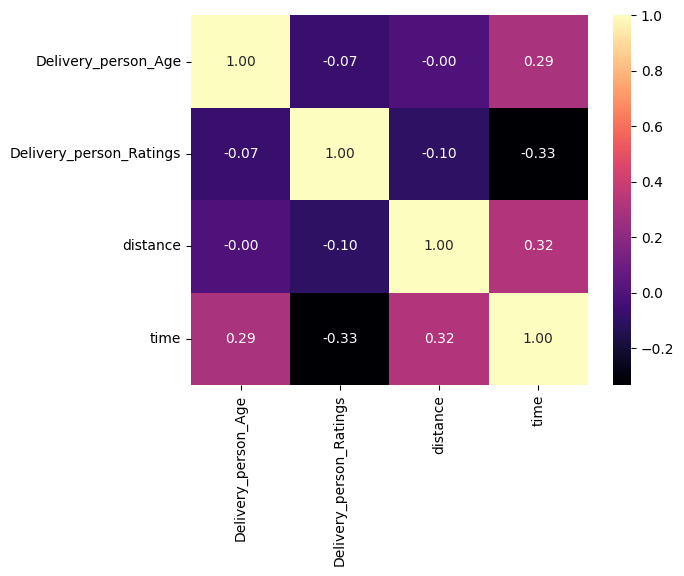

In [24]:
# univariate analysis 
X=df[["Person_ID", "Delivery_person_Age","Delivery_person_Ratings","restaurant_id", "Type_of_vehicle", "Type_of_order", "time", "distance"]]
sns.heatmap(X[["Delivery_person_Age", "Delivery_person_Ratings","distance", "time"]].corr(), annot=True, fmt=".2f", cmap="magma")

<Axes: >

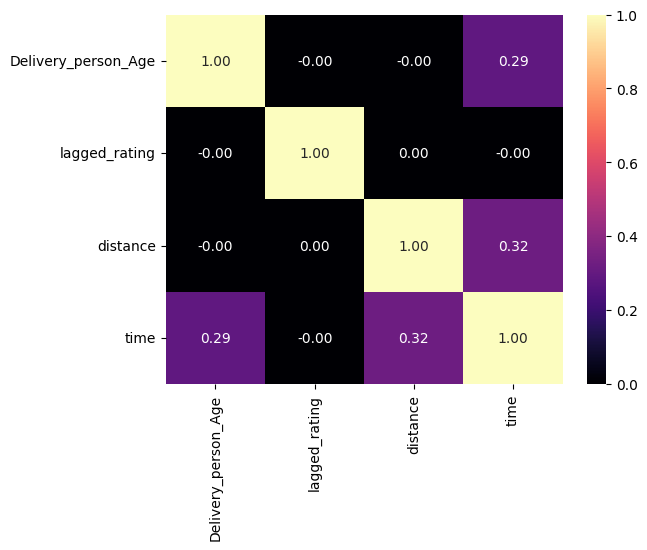

In [25]:
# a rating in period t is endogenous to the delivery time in proid t -> they receive a bad rating because of a slow delivery. 
#to avoid that I use the previous rating from period t-1 to explain delivery time in period t
Xlag=X.copy()
Xlag['lagged_rating'] = df['Delivery_person_Ratings'].shift(1)
# Drop the NaN value in the first row resulting from the shift
Xlag = Xlag.dropna()
sns.heatmap(Xlag[["Delivery_person_Age", "lagged_rating","distance", "time"]].corr(), annot=True, fmt=".2f", cmap="magma")


The delivery persons' age and distance seem related to delivery time. The previous ratings of a delivery person are not assocaited with delivery time. 

<Axes: xlabel='distance', ylabel='time'>

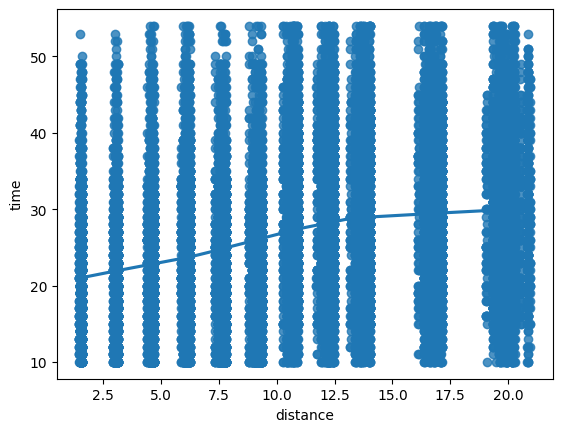

In [26]:
## relationship between distance and delivery time 
sns.regplot(x=df['distance'], y=df["time"], lowess=True)
# time does not increase above distance of 15km 

<Axes: xlabel='Delivery_person_Age', ylabel='time'>

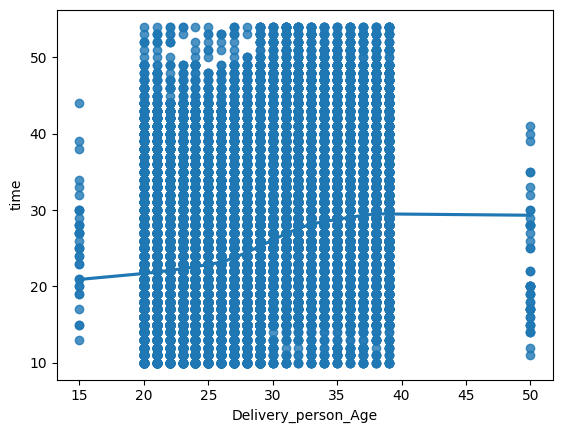

In [27]:
## relationship between age and delivery time 
sns.regplot(x=df['Delivery_person_Age'], y=df["time"], lowess=True)

<Axes: xlabel='Delivery_person_Age', ylabel='distance'>

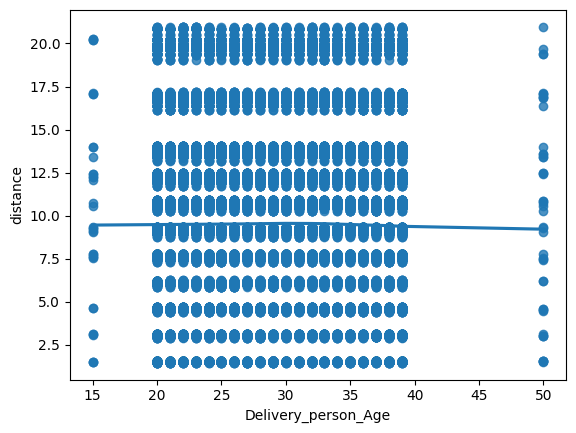

In [28]:
# Interestingly time increases with age. Is this because older delivery persons receive longer distances? 
sns.regplot(x=df['Delivery_person_Age'], y=df["distance"], lowess=True)
# no it is not.  

## Relationship between time and categorical factors

<Axes: xlabel='Type_of_vehicle', ylabel='time'>

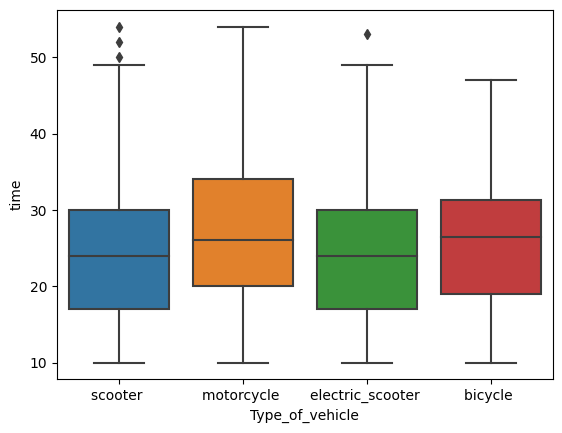

In [29]:
## realtionship between categrical variables and time 
# time and type of vehicle 
sns.boxplot(data=df, x="Type_of_vehicle", y="time")

<Axes: xlabel='Type_of_order', ylabel='time'>

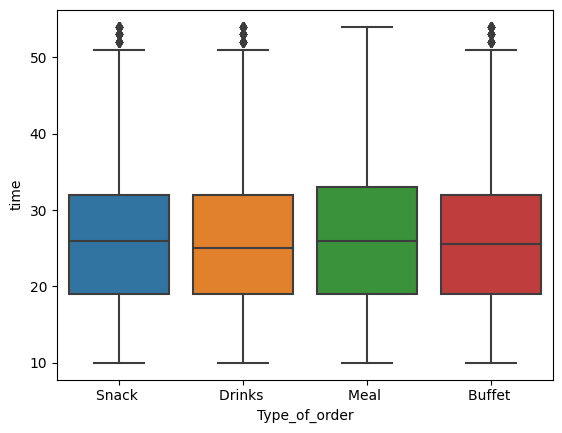

In [30]:
sns.boxplot(data=df, x="Type_of_order", y="time")

# Prediction models 

In [31]:

from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
import scipy.stats


# preparting the dataset 
y=df["time"]
X=df[["Delivery_person_Age", "distance"]]

# normalize the continous predictors 
def normalize (x): 
    return ( (x-np.min(x))/ (max(x) - min(x)))                                                         
X = X.apply(normalize) 

# add categorical variables 
X_type=pd.get_dummies(df["Type_of_vehicle"], prefix="type", drop_first=True)
X=pd.concat([X, X_type], axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=78946513)

models = {
    'OLS': LinearRegression(),
    'Poly': make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    'Bayes': BayesianRidge(),
    'KNN': KNeighborsRegressor(n_neighbors=10),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'gbt_model': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Fit, predict, and evaluate models 
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    scores_MAE = cross_val_score(model, X, y, cv=10, scoring=make_scorer(mean_absolute_error))
    sem_MAE = scipy.stats.sem(scores_MAE)
    scores_MSE = cross_val_score(model, X, y, cv=10, scoring=make_scorer(mean_squared_error))
    sem_MSE = scipy.stats.sem(scores_MSE)
    
    mse = mean_squared_error(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    print(f"{name}: Mean absolute error: {np.mean(scores_MAE):.3f} ± {sem_MAE * 1.96:.3f},  Mean squared error: {np.mean(scores_MSE):.3f} ± {sem_MSE * 1.96:.3f}")
print("Confidence Intervals calculated using CV")

OLS: Mean absolute error: 6.714 ± 0.043,  Mean squared error: 69.055 ± 0.795
Poly: Mean absolute error: 6.677 ± 0.036,  Mean squared error: 68.183 ± 0.711
Bayes: Mean absolute error: 6.714 ± 0.043,  Mean squared error: 69.055 ± 0.795
KNN: Mean absolute error: 6.703 ± 0.061,  Mean squared error: 70.044 ± 1.053
Random Forest: Mean absolute error: 7.276 ± 0.061,  Mean squared error: 83.862 ± 1.334
gbt_model: Mean absolute error: 6.434 ± 0.041,  Mean squared error: 63.810 ± 0.742
Confidence Intervals calculated using CV


## Prediction intervals 

Text(0, 0.5, 'predicted delivery time')

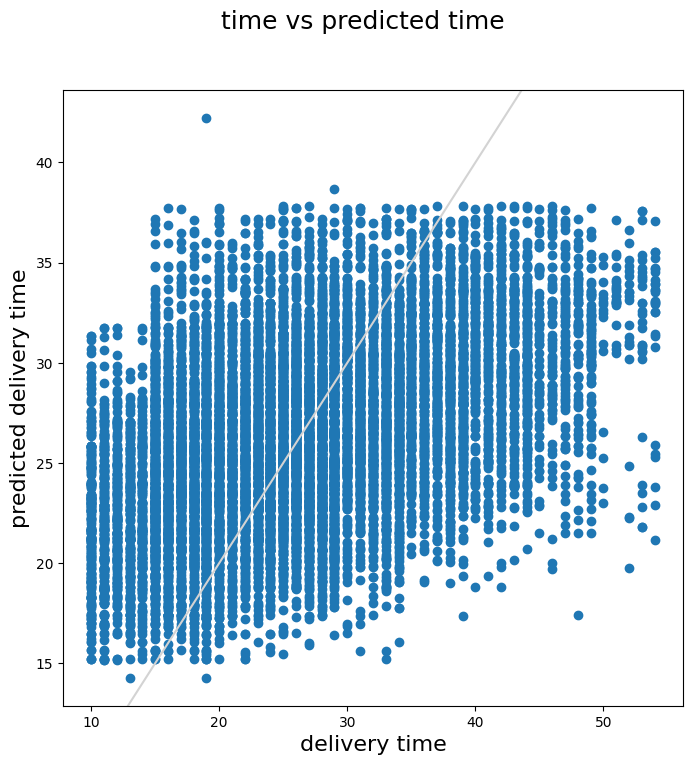

In [32]:
### how well can the model predict with the given data?  
# Plotting y_test and y_pred to understand the spread. Example Poly (because of computation time)
models = {
    'Poly': make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
}

# Fit, predict, and evaluate models 
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

fig = plt.figure(figsize=(8, 8))
plt.scatter(y_test,preds)
plt.plot(plt.xlim(), plt.xlim(), color="lightgray", scalex=False, scaley=False)
fig.suptitle('time vs predicted time', fontsize=18)        # Plot heading 
plt.xlabel('delivery time', fontsize=16)                   # X-label
plt.ylabel('predicted delivery time', fontsize=16)         # Y-label

### what would be the uncertainty around the predicted time of X_n+1? e.g. driver is 40 years old and distance is 5 km? 

Overall, it seems that the available features do not have much predictive power. 

In [34]:
# Using Mapie to calculate prediction intervals 
! pip install mapie 
from mapie.metrics import regression_coverage_score
from mapie.regression import MapieRegressor

models = {
    'Poly': make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    'Bayes': BayesianRidge(),
    'gbt_model': GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

for name, model in models.items():
    mapie = MapieRegressor(model, cv=10, agg_function="median")
    mapie.fit(X_train, y_train)
    preds, preds_pis = mapie.predict(X_test, alpha=[0.05])  # pis: prediction intervals 
    y_err = np.abs(preds_pis[:, :, 0].T - preds)            # y_err is the difference from the mean top the boprder of the CI, so the CI width is:  y_err *2 
    
    # Print out statistics
    mae_test = mean_absolute_error(y_test, preds)
    coverage = regression_coverage_score(y_test, preds_pis[:, 0, 0], preds_pis[:, 1, 0])
    print(f"{name}: MAE: {mae_test:.3f}, Width of 95% prediction interval: {np.mean(y_err) * 2:.3f}, Coverage: {coverage:.3f}")
    print(f"The actual value of any new prediction is expected to lie between the prediction value ± {np.mean(y_err):.3f}")

# The effective coverage is the actual fraction of true values/labels lying in the prediction intervals.
# if we predict 20 mins delivery time for a new datapoint X_n+1, the actual value will in 95% of cases lie somewhere between 4 and 36 mins. 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.8/137.8 kB 2.9 MB/s eta 0:00:00a 0:00:01


/opt/conda/lib/python3.10/site-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions have issues.
The upper predictions are lower thanthe lower predictions at some points.
  warnings.warn(


Poly: MAE: 6.683, Width of 95% prediction interval: 31.580, Coverage: 0.948
The actual value of any new prediction is expected to lie between the prediction value ± 15.790


/opt/conda/lib/python3.10/site-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions have issues.
The upper predictions are lower thanthe lower predictions at some points.
  warnings.warn(


Bayes: MAE: 6.720, Width of 95% prediction interval: 31.935, Coverage: 0.950
The actual value of any new prediction is expected to lie between the prediction value ± 15.967
gbt_model: MAE: 6.453, Width of 95% prediction interval: 30.845, Coverage: 0.950
The actual value of any new prediction is expected to lie between the prediction value ± 15.422


/opt/conda/lib/python3.10/site-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions have issues.
The upper predictions are lower thanthe lower predictions at some points.
  warnings.warn(
